# Fashion-MNIST GAN
Disclaimer: This notebook is an adopted version of [this](https://github.com/mickypaganini/GAN_tutorial) and [this](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) tutorials.
<img src="static/fashion-mnist.png" align="center"/>

## Imports and parameters

In [1]:
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

from sklearn.cluster import MiniBatchKMeans

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch_size = 100

## Dataset
In this tutorial we'll use [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). In short: Fashion-MNIST is like MNIST but with fashion items (shirts, shoes, etc.).

Let's setup transforms and dataset:

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [5]:
dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

Processing...
Done!


Function to back from [-1, 1] to [0, 1]:

In [6]:
def denorm(x):
    out = (x + 1) / 2
    return out

Explore dataset:

In [7]:
print("Labels: ", np.unique(dataset.train_labels))

Labels:  [0 1 2 3 4 5 6 7 8 9]


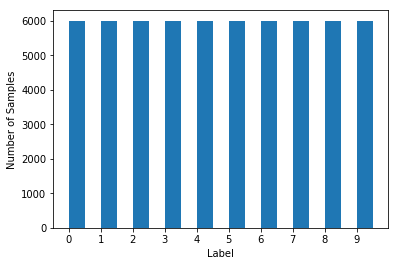

In [8]:
plt.hist(dataset.train_labels, bins=np.linspace(0, 9.5, 20))

plt.xticks(range(10))
plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.show()

Plot some examples:

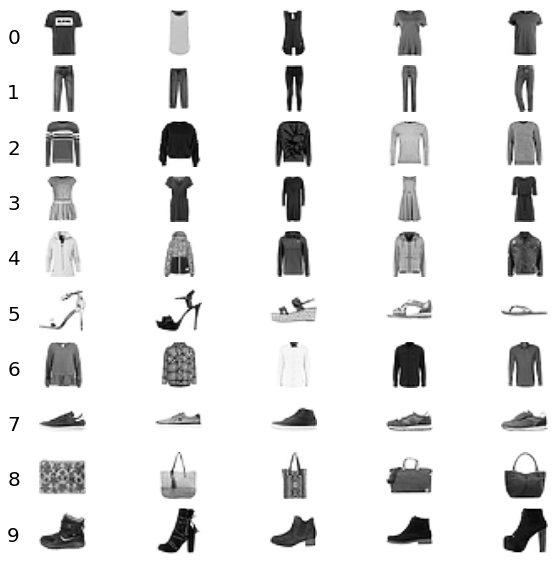

In [9]:
n_images = 5

fig, axes = plt.subplots(len(np.unique(dataset.train_labels)), n_images, figsize=(10, 10))
# fig.subplots_adjust(wspace=-0.7)

for label in np.unique(dataset.train_labels):
    axes[label, 0].text(-20, 20, str(label), size=20)
    
    for image_i, image in enumerate(dataset.train_data.numpy()[dataset.train_labels.numpy() == label][:n_images]):
        axes[label, image_i].imshow(image, interpolation='bilinear', cmap='Greys')
        axes[label, image_i].axis('off')

Setup dataloader:

In [10]:
dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size, 
    shuffle=True,
    num_workers=2
)

## What is GAN?

GANs are a framework for teaching a DL model to capture the training data’s distribution so we can generate new data from that same distribution. GANs were invented by Ian Goodfellow in 2014 and first
described in the paper [Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf). They are made of two distinct models, a *generator* and a *discriminator*. The job of the generator is to spawn ‘fake’ images that look like the training images. The job of the discriminator is to look at an image and output whether or not it is a real training image or a fake image from the generator. During training, the generator is constantly trying to outsmart the discriminator by generating better and better fakes, while the discriminator is working to become a better detective and correctly classify the real and fake images. The equilibrium of this game is when the generator is generating perfect fakes that look as if they came directly from the training data, and the discriminator is left to always guess at 50% confidence that the generator output is real or fake.

Now, lets define some notation to be used throughout tutorial starting with the discriminator. Let $x$ be data representing an image. $D(x)$ is the discriminator network which outputs the (scalar) probability that $x$ came from training data rather than the generator. Here, since we are dealing with images the input to $D(x)$ is an image of size 28x28. Intuitively, $D(x)$ should be HIGH when $x$ comes from training data and LOW when $x$ comes from the generator. $D(x)$ can also be thought of as a traditional binary classifier.

For the generator’s notation, let $z$ be a latent space vector sampled from a standard normal distribution. $G(z)$ represents the generator function which maps the latent vector $z$ to data-space. The goal of $G$ is to estimate the distribution that the training data comes from ($p_{data}$) so it can generate fake samples from that estimated distribution ($p_g$).

So, $D(G(z))$ is the probability (scalar) that the output of the generator $G$ is a real image. As described in Goodfellow’s paper, $D$ and $G$ play a minimax game in which $D$ tries to maximize the probability it correctly classifies reals and fakes ($logD(x)$), and $G$ tries to minimize the probability that $D$ will predict its outputs are fake ($log(1-D(G(x)))$).

From the paper, the GAN loss function is

\begin{align}\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(x)))\big]\end{align}

In theory, the solution to this minimax game is where $p_g = p_{data}$, and the discriminator guesses randomly if the inputs are real or fake. However, the convergence theory of GANs is still being actively researched and in reality models do not always

## Task 1 (1 point). Model

GAN consits of two main parts:
1. **Generator**: generates images from noise vector
2. **Discriminator**: classifies real images from generated (fake) ones

### Generator
The generator, $G$, is designed to map the latent space vector ($z$) to data-space. Since our data are images, converting $z$ to data-space means ultimately creating a image with the same size as the training images (i.e. 28x28). In practice, this is
accomplished through a series of strided two dimensional convolutional transpose layers, but for simplicity we'll use linear model. The output of the generator is fed through a tanh function
to return it to the input data range of $[-1,1]$.

That's how our generator will work: it takes noise vector of shape **nz**, process it with 5 linear layers (with **256** neurons each) and outputs image (vector of shape **784** = 28x28) pushing it through [Tanh](https://pytorch.org/docs/stable/nn.html#torch.nn.Tanh) activation function. As a nonlinearity we'll use [Leacky ReLU](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU) with negative slope parameter of **0.2**. Let's implement generator:

In [11]:
nz = 64

G = nn.Sequential(
    nn.Linear(nz, 256),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    nn.Linear(256, 256),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    nn.Linear(256, 256),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    nn.Linear(256, 256),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    nn.Linear(256, 784),
    nn.Tanh()
).to(device)

### Discriminator

As mentioned, the discriminator, $D$, is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake). Here, $D$ takes a 28x28 input image, processes it through a series of linear layers with nonlinearities and outputs the final probability through a Sigmoid activation function.

That's how our discriminator will work: it takes image (vector of shape **784** = 28x28), process it with 5 linear layers (with **256** neurons each) and outputs classification score (vector of size 1) pushing it through [Sigmoid](https://pytorch.org/docs/stable/nn.html#torch.nn.Sigmoid) activation function. As a nonlinearity we'll also use [Leacky ReLU](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU) with negative slope parameter of **0.2**. Let's implement discriminator:

In [12]:
# Discriminator
D = nn.Sequential(
    nn.Linear(784, 256),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    nn.Linear(256, 256),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    nn.Linear(256, 256),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    nn.Linear(256, 256),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    nn.Linear(256, 1),
    nn.Sigmoid()
).to(device)

## Loss functions and optimizers

With $D$ and $G$ setup, we can specify how they learn through the loss functions and optimizers. We will use the [Binary Cross Entropy loss](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss) function which is defined in PyTorch as:

\begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}

Notice how this function provides the calculation of both log components in the objective function (i.e. $log(D(x))$ and $log(1-D(G(z)))$). We can specify what part of the BCE equation to use with the $y$ input. This is accomplished in the training loop which is coming up soon, but it is important to understand how we can choose which component we wish to calculate just by changing $y$ (i.e. GT labels).

Next, we define our real label as 1 and the fake label as 0. These labels will be used when calculating the losses of $D$ and $G$, and this is also the convention used in the original GAN paper. Finally, we set up two separate optimizers, one for $D$ and
one for $G$.

In [13]:
criterion = nn.BCELoss()

real_label = 1
fake_label = 0

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0003)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0003)

For keeping track of the generator’s learning progression, we will generate a fixed batch of latent vectors that are drawn from a Gaussian distribution (i.e. fixed_noise) . In the training loop, we will periodically input this fixed_noise into $G$, and over the iterations we will see images form out of the noise:

In [14]:
fixed_noise = torch.randn(64, nz).to(device)

## Task 2 (3 points). Train-loop

Make dirs to store training progress:

In [15]:
os.makedirs("./images", exist_ok=True)
os.makedirs("./weights", exist_ok=True)

PyTorch allows you to build **dynamic graphs** in a very intuitive and pythonic way. 

You should write the training loop yourself, looping through the epochs and the batches.

Although this adds additional boilerplate and room for error when compared to libraries like Keras, this dynamic construction gives the flexibility required for exotic train loops that do not fit the `model.fit(...)` paradigm, such as GANs.

In [17]:
n_epochs = 200

for epoch in range(n_epochs):
    for batch_number, (images, _) in enumerate(dataloader):
        current_batch_size = images.shape[0]
        
        # reshape training dataset images from (batch_size, 28, 28) to (batch_size, 28*28) for processing through fully-connected net
        images = images.view(current_batch_size, -1).to(device)

        # create targets for the discriminator network D (fill it with real_label or fake_label value)
        real_labels = torch.ones(batch_size).to(device) * real_label
        fake_labels = torch.ones(batch_size).to(device) * fake_label

        # 1) Train discriminator
        
        # evaluate the discriminator on the real input images
        real_scores = D(images)
        
        # compute the discriminator loss with respect to the real labels
        d_loss_real = criterion(real_scores, real_labels)

        # draw random nz-dimensional noise vectors as inputs to the generator network
        z = torch.randn(current_batch_size, nz).to(device) # the latents space is nz
        
        # transform the noise through the generator network to get synthetic images
        fake_images = G(z)
        
        # evaluate the discriminator on the fake images
        fake_scores = D(fake_images)
        
        # compute the discriminator loss with respect to the fake labels
        d_loss_fake = criterion(fake_scores, fake_labels)

        # backprop + optimize the discriminator
        d_loss = d_loss_real + d_loss_fake
        
        D.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # 2) Train generator
        
        # draw random nz-dimensional noise vectors as inputs to the generator network
        z = torch.randn(current_batch_size, nz).to(device)
        
        # transform the noise through the generator network to get synthetic images
        fake_images = G(z)
        
        # evaluate the (new) discriminator on the fake images
        fake_scores = D(fake_images)

        # compute the cross-entropy loss with "real" as target (1s). This is what the G wants to do
        g_loss = criterion(fake_scores, real_labels)

        # backprop + optimize the generator
        D.zero_grad()
        G.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        if (batch_number + 1) % 300 == 0:
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                  'g_loss: %.4f, Mean D(x): %.2f, Mean D(G(z)): %.2f' 
                  %(epoch,
                    n_epochs,
                    batch_number + 1,
                    len(dataloader),
                    d_loss.item(),
                    g_loss.item(),
                    real_scores.mean(),
                    fake_scores.mean())
            )
    
    # Save fixed noise images
    fixed_noise_images = G(fixed_noise)
    fixed_noise_images = fixed_noise_images.view(fixed_noise_images.shape[0], 1, 28, 28)
    torchvision.utils.save_image(denorm(fixed_noise_images), './images/fixed_noise_images-%0.3d.png' % (epoch + 1))

    # Save the trained parameters 
    torch.save(G.state_dict(), './weights/generator-%0.3d.pkl' % (epoch + 1))
    torch.save(D.state_dict(), './weights/discriminator-%0.3d.pkl' % (epoch + 1))

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch [0/200], Step[300/600], d_loss: 0.0218, g_loss: 6.5494, Mean D(x): 1.00, Mean D(G(z)): 0.00
Epoch [0/200], Step[600/600], d_loss: 0.2566, g_loss: 4.3301, Mean D(x): 0.96, Mean D(G(z)): 0.02
Epoch [1/200], Step[300/600], d_loss: 0.1314, g_loss: 4.5205, Mean D(x): 0.97, Mean D(G(z)): 0.02
Epoch [1/200], Step[600/600], d_loss: 0.3480, g_loss: 2.3705, Mean D(x): 0.93, Mean D(G(z)): 0.15
Epoch [2/200], Step[300/600], d_loss: 0.3469, g_loss: 3.6164, Mean D(x): 0.92, Mean D(G(z)): 0.04
Epoch [2/200], Step[600/600], d_loss: 0.0873, g_loss: 4.4109, Mean D(x): 0.99, Mean D(G(z)): 0.03
Epoch [3/200], Step[300/600], d_loss: 0.1527, g_loss: 4.6564, Mean D(x): 0.94, Mean D(G(z)): 0.03
Epoch [3/200], Step[600/600], d_loss: 0.1493, g_loss: 4.4497, Mean D(x): 0.95, Mean D(G(z)): 0.01
Epoch [4/200], Step[300/600], d_loss: 0.3138, g_loss: 3.9586, Mean D(x): 0.92, Mean D(G(z)): 0.07
Epoch [4/200], Step[600/600], d_loss: 0.2264, g_loss: 2.9622, Mean D(x): 0.93, Mean D(G(z)): 0.09
Epoch [5/200], Step[

Epoch [41/200], Step[600/600], d_loss: 0.6350, g_loss: 2.5486, Mean D(x): 0.75, Mean D(G(z)): 0.18
Epoch [42/200], Step[300/600], d_loss: 0.7028, g_loss: 1.9769, Mean D(x): 0.79, Mean D(G(z)): 0.20
Epoch [42/200], Step[600/600], d_loss: 0.9344, g_loss: 1.3587, Mean D(x): 0.71, Mean D(G(z)): 0.29
Epoch [43/200], Step[300/600], d_loss: 0.6989, g_loss: 1.5749, Mean D(x): 0.83, Mean D(G(z)): 0.27
Epoch [43/200], Step[600/600], d_loss: 0.6476, g_loss: 1.6367, Mean D(x): 0.83, Mean D(G(z)): 0.24
Epoch [44/200], Step[300/600], d_loss: 0.6429, g_loss: 1.9484, Mean D(x): 0.79, Mean D(G(z)): 0.19
Epoch [44/200], Step[600/600], d_loss: 1.0990, g_loss: 2.0712, Mean D(x): 0.66, Mean D(G(z)): 0.19
Epoch [45/200], Step[300/600], d_loss: 0.7180, g_loss: 1.9901, Mean D(x): 0.77, Mean D(G(z)): 0.22
Epoch [45/200], Step[600/600], d_loss: 0.6996, g_loss: 1.7300, Mean D(x): 0.76, Mean D(G(z)): 0.23
Epoch [46/200], Step[300/600], d_loss: 0.6839, g_loss: 1.8001, Mean D(x): 0.81, Mean D(G(z)): 0.22
Epoch [46/

Epoch [83/200], Step[300/600], d_loss: 0.9282, g_loss: 1.3458, Mean D(x): 0.69, Mean D(G(z)): 0.29
Epoch [83/200], Step[600/600], d_loss: 1.0178, g_loss: 1.2027, Mean D(x): 0.70, Mean D(G(z)): 0.34
Epoch [84/200], Step[300/600], d_loss: 0.9526, g_loss: 1.4304, Mean D(x): 0.69, Mean D(G(z)): 0.27
Epoch [84/200], Step[600/600], d_loss: 0.7641, g_loss: 1.4623, Mean D(x): 0.73, Mean D(G(z)): 0.27
Epoch [85/200], Step[300/600], d_loss: 0.9346, g_loss: 1.2852, Mean D(x): 0.77, Mean D(G(z)): 0.32
Epoch [85/200], Step[600/600], d_loss: 0.9306, g_loss: 1.3909, Mean D(x): 0.68, Mean D(G(z)): 0.30
Epoch [86/200], Step[300/600], d_loss: 0.9431, g_loss: 1.4051, Mean D(x): 0.74, Mean D(G(z)): 0.30
Epoch [86/200], Step[600/600], d_loss: 1.0519, g_loss: 1.3913, Mean D(x): 0.66, Mean D(G(z)): 0.30
Epoch [87/200], Step[300/600], d_loss: 0.9344, g_loss: 1.4871, Mean D(x): 0.71, Mean D(G(z)): 0.28
Epoch [87/200], Step[600/600], d_loss: 0.9106, g_loss: 1.5321, Mean D(x): 0.66, Mean D(G(z)): 0.26
Epoch [88/

Epoch [124/200], Step[600/600], d_loss: 1.1403, g_loss: 1.2002, Mean D(x): 0.64, Mean D(G(z)): 0.32
Epoch [125/200], Step[300/600], d_loss: 1.1734, g_loss: 1.2205, Mean D(x): 0.64, Mean D(G(z)): 0.35
Epoch [125/200], Step[600/600], d_loss: 1.0811, g_loss: 1.5056, Mean D(x): 0.65, Mean D(G(z)): 0.27
Epoch [126/200], Step[300/600], d_loss: 1.1166, g_loss: 1.2481, Mean D(x): 0.66, Mean D(G(z)): 0.32
Epoch [126/200], Step[600/600], d_loss: 1.1211, g_loss: 1.0933, Mean D(x): 0.65, Mean D(G(z)): 0.37
Epoch [127/200], Step[300/600], d_loss: 1.0974, g_loss: 1.0602, Mean D(x): 0.64, Mean D(G(z)): 0.38
Epoch [127/200], Step[600/600], d_loss: 0.9821, g_loss: 1.6247, Mean D(x): 0.63, Mean D(G(z)): 0.25
Epoch [128/200], Step[300/600], d_loss: 0.9096, g_loss: 1.1809, Mean D(x): 0.69, Mean D(G(z)): 0.33
Epoch [128/200], Step[600/600], d_loss: 0.9183, g_loss: 1.0897, Mean D(x): 0.72, Mean D(G(z)): 0.37
Epoch [129/200], Step[300/600], d_loss: 1.0166, g_loss: 1.2390, Mean D(x): 0.63, Mean D(G(z)): 0.33


Epoch [165/200], Step[600/600], d_loss: 0.9960, g_loss: 1.4866, Mean D(x): 0.61, Mean D(G(z)): 0.26
Epoch [166/200], Step[300/600], d_loss: 0.9514, g_loss: 1.4221, Mean D(x): 0.65, Mean D(G(z)): 0.28
Epoch [166/200], Step[600/600], d_loss: 1.0763, g_loss: 1.3247, Mean D(x): 0.62, Mean D(G(z)): 0.32
Epoch [167/200], Step[300/600], d_loss: 1.0429, g_loss: 1.1368, Mean D(x): 0.65, Mean D(G(z)): 0.36
Epoch [167/200], Step[600/600], d_loss: 1.0937, g_loss: 1.2686, Mean D(x): 0.67, Mean D(G(z)): 0.32
Epoch [168/200], Step[300/600], d_loss: 0.9995, g_loss: 1.1497, Mean D(x): 0.66, Mean D(G(z)): 0.34
Epoch [168/200], Step[600/600], d_loss: 1.2165, g_loss: 1.0776, Mean D(x): 0.59, Mean D(G(z)): 0.37
Epoch [169/200], Step[300/600], d_loss: 1.1015, g_loss: 1.2383, Mean D(x): 0.60, Mean D(G(z)): 0.32
Epoch [169/200], Step[600/600], d_loss: 1.1711, g_loss: 1.1852, Mean D(x): 0.63, Mean D(G(z)): 0.34
Epoch [170/200], Step[300/600], d_loss: 1.0832, g_loss: 1.1875, Mean D(x): 0.61, Mean D(G(z)): 0.33


## Evaluation

Create video from generated images from fixed noise epoch-wise:

In [19]:
subprocess.call([
    'ffmpeg', '-y', '-framerate', '8', '-i', './images/fixed_noise_images-%03d.png', '-r', '30', '-pix_fmt', 'yuv420p',
    'fixed_noise_images.mp4'
])

0

Load your favorite epoch:

In [20]:
G.load_state_dict(torch.load('./weights/generator-200.pkl'))
D.load_state_dict(torch.load('./weights/discriminator-200.pkl'))

Now let's generate some images from random vectors:

In [21]:
z = torch.randn(60000, nz).to(device)
fake_images = G(z).detach().cpu().numpy().reshape(60000, 28, 28)

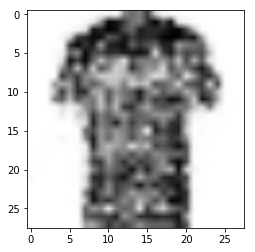

In [22]:
plt.imshow(fake_images[0], cmap='Greys', interpolation='bilinear')

Now let's analyze our generated images with cluster analysis:

In [23]:
inertia = []
normed_real_images = dataset.train_data.numpy().reshape(len(dataset), -1) / 255. * 2. - 1.
for n_clusters in range(2, 15):
    model = MiniBatchKMeans(n_clusters=n_clusters)
    model.fit(normed_real_images)
    inertia.append(model.inertia_)

In [24]:
inertia_gan = []
for n_clusters in range(2, 15):
    model = MiniBatchKMeans(n_clusters=n_clusters)
    model.fit(fake_images.reshape(60000, -1))
    inertia_gan.append(model.inertia_)

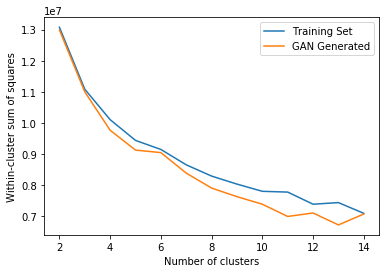

In [25]:
plt.plot(range(2, 15), inertia, label='Training Set')
plt.plot(range(2, 15), inertia_gan, label='GAN Generated')
plt.legend()
plt.ylabel('Within-cluster sum of squares')
plt.xlabel('Number of clusters');